In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import statsmodels as sm
%matplotlib inline

In [2]:
wildlife = pd.read_csv('../clean_data/wildlife_clean.csv', parse_dates=['CALL_SAVED_TIME'])

In [3]:
wildlife.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152743 entries, 0 to 152742
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Unnamed: 0       152743 non-null  int64         
 1   CALL_REGION      152743 non-null  object        
 2   CALL_SAVED_TIME  152672 non-null  datetime64[ns]
 3   CA_ANIMAL_TYPE   152743 non-null  object        
 4   reason_for_call  152743 non-null  object        
 5   type_of_calls    152743 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 7.0+ MB


In [4]:
wildlife.head()

,Unnamed: 0,CALL_REGION,CALL_SAVED_TIME,CA_ANIMAL_TYPE,reason_for_call,type_of_calls
0,0,Central,2020-01-01,Deer,rescue,report_calls
1,1,Central,2020-01-01,Deer,rescue,report_calls
2,2,Central,2020-01-01,Deer,rescue,report_calls
3,3,Aberdeen,2020-01-01,Wild Bird,injury,report_calls
4,4,Central,2020-01-01,Gull,injury,report_calls


# Prediction of injuries calls

In [5]:
wildlife_injuries = wildlife[wildlife['reason_for_call']=='injury'].copy()
df_time = wildlife_injuries.groupby(['CALL_SAVED_TIME']).count()
df_time

,Unnamed: 0,CALL_REGION,CA_ANIMAL_TYPE,reason_for_call,type_of_calls
CALL_SAVED_TIME,,,,,
2018-01-01,34,34,34,34,34
2018-01-02,33,33,33,33,33
2018-01-03,44,44,44,44,44
2018-01-04,29,29,29,29,29
2018-01-05,44,44,44,44,44
...,...,...,...,...,...
2020-04-26,101,101,101,101,101
2020-04-27,93,93,93,93,93
2020-04-28,85,85,85,85,85


In [6]:
df_time.shape

(851, 5)

In [7]:
# to find 20% of all rows
851 *0.2
851 - 170

681

In [8]:
train=df_time[0:681] 
test=df_time[681:]

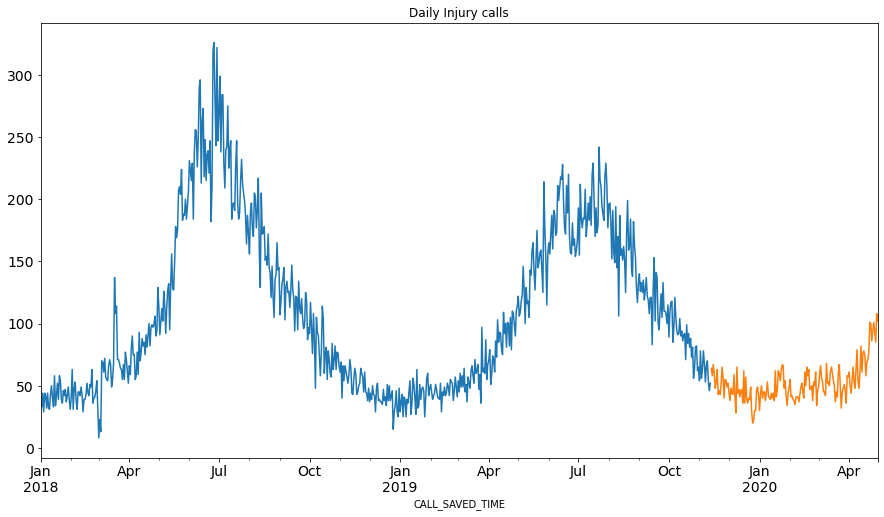

In [9]:
train.reason_for_call.plot(figsize=(15,8), title= 'Daily Injury calls', fontsize=14)
test.reason_for_call.plot(figsize=(15,8), title= 'Daily Injury calls', fontsize=14)
plt.show()

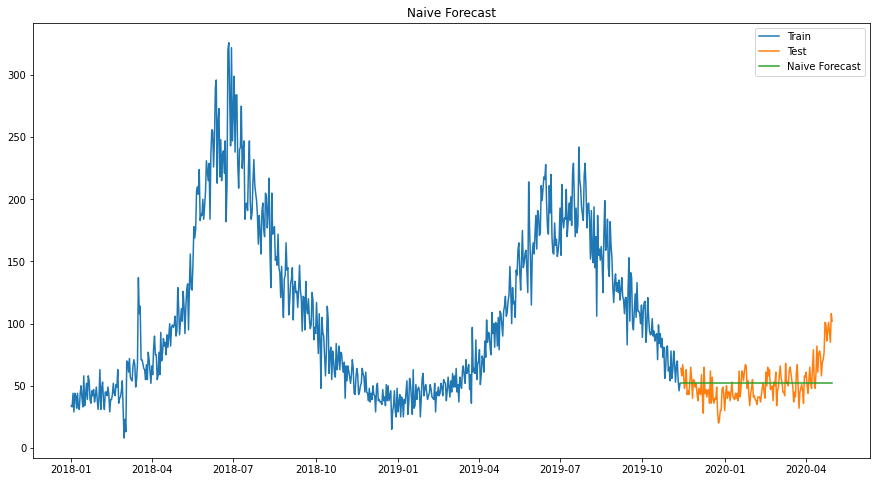

In [10]:
dd= np.asarray(train.reason_for_call)
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(15,8))
plt.plot(train.index, train['reason_for_call'], label='Train')
plt.plot(test.index,test['reason_for_call'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

In [11]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test.reason_for_call, y_hat.naive))
print(rms)

15.38907175276549


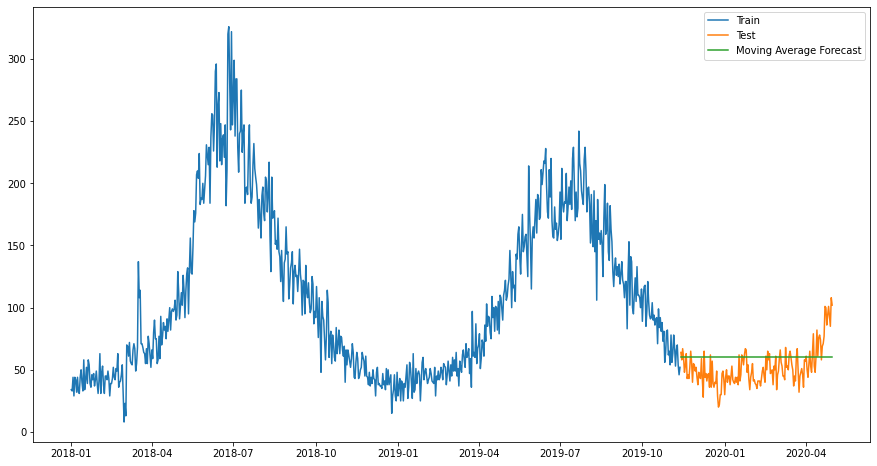

In [12]:
y_hat_avg = test.copy()
y_hat_avg['moving_avg_forecast'] = train['reason_for_call'].rolling(10).mean().iloc[-1]
plt.figure(figsize=(15,8))
plt.plot(train['reason_for_call'], label='Train')
plt.plot(test['reason_for_call'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

In [13]:
rms = sqrt(mean_squared_error(test.reason_for_call, y_hat_avg.moving_avg_forecast))
print(rms)

17.473408368146153


/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


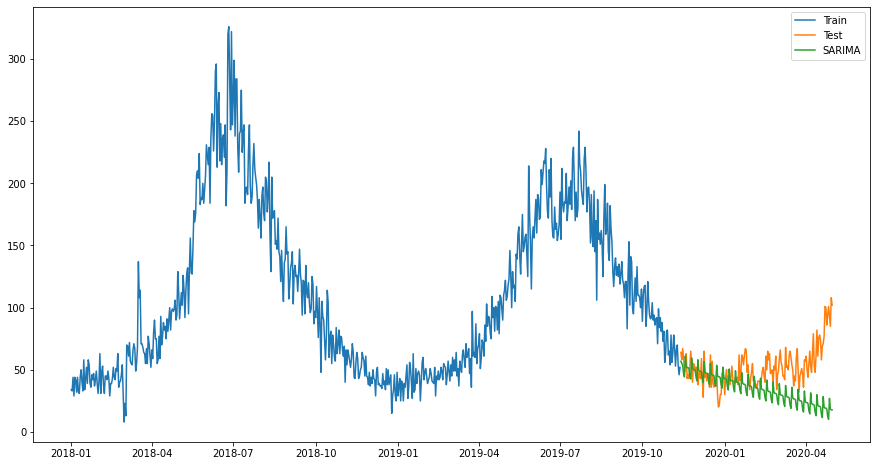

In [14]:
import statsmodels.api as sm

y_hat_avg = test.copy()
fit1 = sm.tsa.statespace.SARIMAX(train.reason_for_call, order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit()
y_hat_avg['SARIMA'] = fit1.predict(start="2019-11-13", end="2020-04-30", dynamic=True)
plt.figure(figsize=(15,8))
plt.plot( train['reason_for_call'], label='Train')
plt.plot(test['reason_for_call'], label='Test')
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()

In [15]:
rms = sqrt(mean_squared_error(test.reason_for_call, y_hat_avg.SARIMA))
print(rms)

28.66247948975563


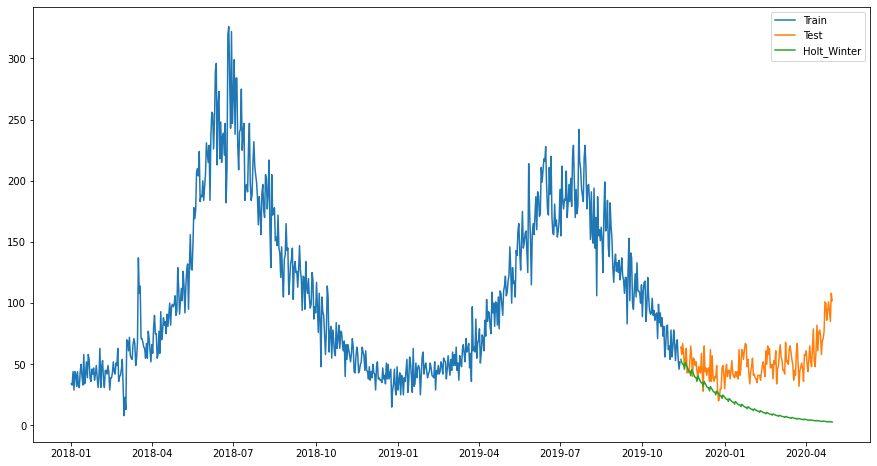

In [16]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt

y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['reason_for_call']) ,seasonal_periods=7 ,trend='mul', seasonal='mul',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize=(15,8))
plt.plot( train['reason_for_call'], label='Train')
plt.plot(test['reason_for_call'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [17]:
rms = sqrt(mean_squared_error(test.reason_for_call, y_hat_avg.Holt_Winter))
print(rms)

42.23063197966881


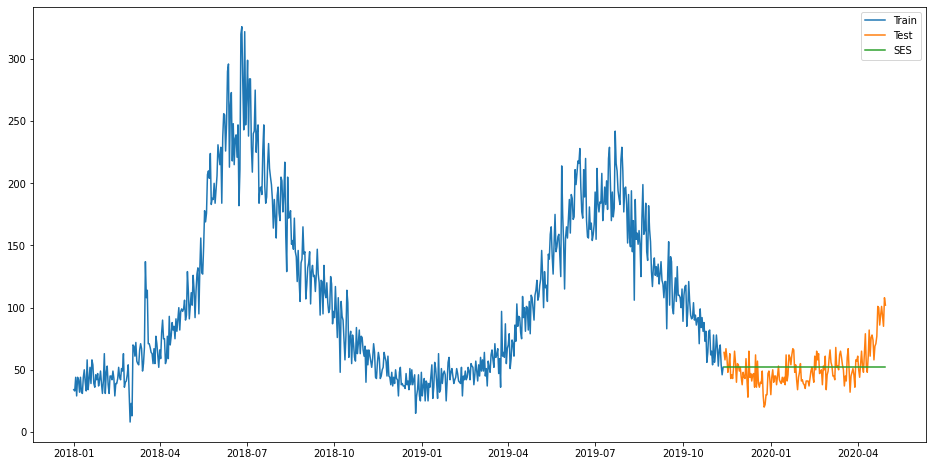

In [18]:
y_hat_avg = test.copy()
fit2 = SimpleExpSmoothing(np.asarray(train['reason_for_call'])).fit(smoothing_level=1,optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot(train['reason_for_call'], label='Train')
plt.plot(test['reason_for_call'], label='Test')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.show()

In [19]:
rms = sqrt(mean_squared_error(test.reason_for_call, y_hat_avg.SES))
print(rms)

15.38907175276549


In [20]:
test = test.reset_index()
train = train.reset_index()

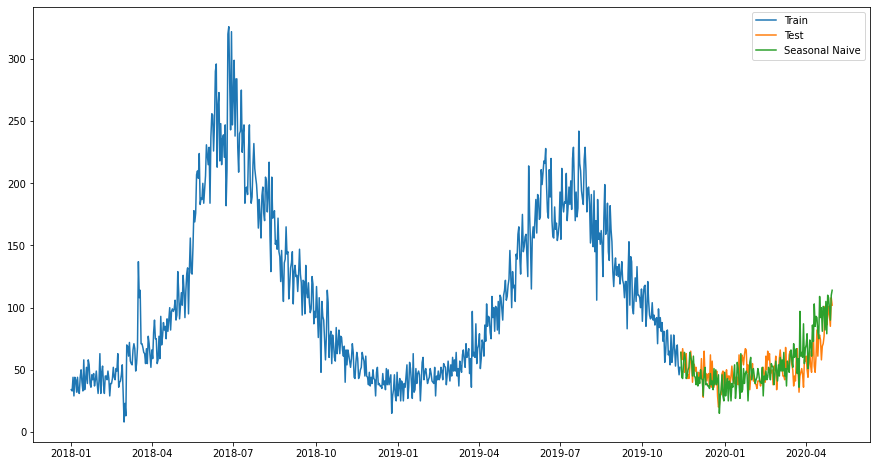

In [21]:
dates = (test['CALL_SAVED_TIME'] - np.timedelta64(1, 'Y')).values.astype('datetime64[D]')
seasonal_naive = train[train['CALL_SAVED_TIME'].isin(dates)]['reason_for_call'] # seasonal naive prediction
y_hat_sn = test.copy().drop('reason_for_call', axis=1)
y_hat_sn['seasonal_naive'] = pd.DataFrame(seasonal_naive).set_index(test.index)
plt.figure(figsize=(15,8))
plt.plot(train['CALL_SAVED_TIME'], train['reason_for_call'], label='Train')
plt.plot(test['CALL_SAVED_TIME'], test['reason_for_call'], label='Test')
plt.plot(y_hat_sn['CALL_SAVED_TIME'], y_hat_sn['seasonal_naive'], label='Seasonal Naive')
plt.legend(loc='best')
plt.show()

In [22]:
rms = sqrt(mean_squared_error(test.reason_for_call, y_hat_sn.seasonal_naive))
print(rms)

15.193264761651692


In [23]:
rng = pd.date_range('2020-05-01', periods=610, freq='D')
df_pred = pd.DataFrame({ 'CALL_SAVED_TIME': rng, 'reason_for_call' : np.random.randn(len(rng))}) 
df_pred

,CALL_SAVED_TIME,reason_for_call
0,2020-05-01,0.512803
1,2020-05-02,-0.871743
2,2020-05-03,-1.520076
3,2020-05-04,0.895973
4,2020-05-05,1.712811
...,...,...
605,2021-12-27,-1.469662
606,2021-12-28,-0.259405
607,2021-12-29,0.731521
608,2021-12-30,2.340943


In [24]:
df_time = df_time.reset_index()

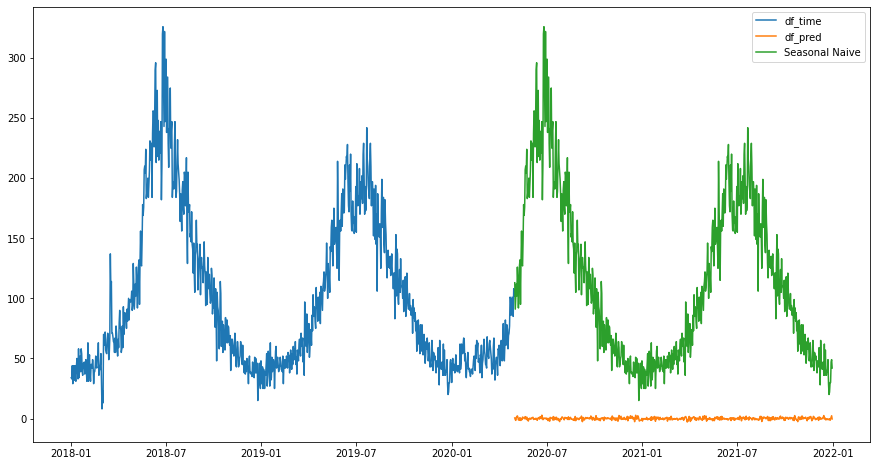

In [25]:
dates = (df_pred['CALL_SAVED_TIME'] - np.timedelta64(2, 'Y')).values.astype('datetime64[D]')
seasonal_naive = df_time[df_time['CALL_SAVED_TIME'].isin(dates)]['reason_for_call'] # seasonal naive prediction
y_hat_sn = df_pred.copy().drop('reason_for_call', axis=1)
y_hat_sn['seasonal_naive'] = pd.DataFrame(seasonal_naive).set_index(df_pred.index)
plt.figure(figsize=(15,8))
plt.plot(df_time['CALL_SAVED_TIME'], df_time['reason_for_call'], label='df_time')
plt.plot(df_pred['CALL_SAVED_TIME'], df_pred['reason_for_call'], label='df_pred')
plt.plot(y_hat_sn['CALL_SAVED_TIME'], y_hat_sn['seasonal_naive'], label='Seasonal Naive')
plt.legend(loc='best')
plt.show()

In [26]:
calls = wildlife.groupby('CALL_SAVED_TIME').count()
calls

,Unnamed: 0,CALL_REGION,CA_ANIMAL_TYPE,reason_for_call,type_of_calls
CALL_SAVED_TIME,,,,,
2018-01-01,59,59,59,59,59
2018-01-02,58,58,58,58,58
2018-01-03,78,78,78,78,78
2018-01-04,67,67,67,67,67
2018-01-05,84,84,84,84,84
...,...,...,...,...,...
2020-04-26,181,181,181,181,181
2020-04-27,194,194,194,194,194
2020-04-28,189,189,189,189,189


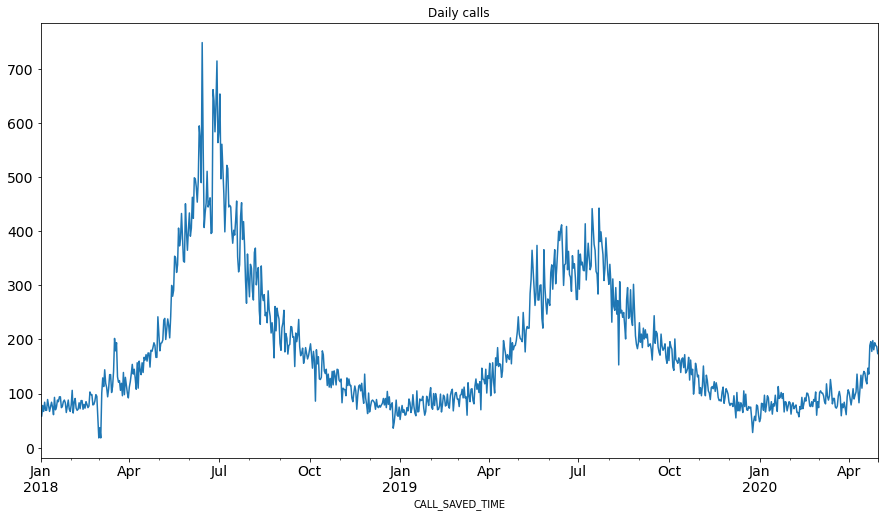

In [27]:
calls.type_of_calls.plot(figsize=(15,8), title= 'Daily calls', fontsize=14)
plt.show()

In [28]:
calls = calls.reset_index()

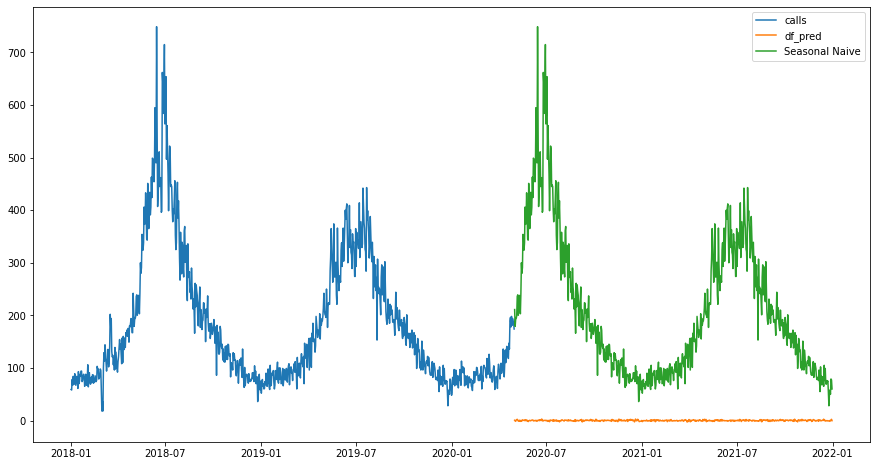

In [29]:
dates = (df_pred['CALL_SAVED_TIME'] - np.timedelta64(2, 'Y')).values.astype('datetime64[D]')
seasonal_naive = calls[calls['CALL_SAVED_TIME'].isin(dates)]['reason_for_call'] # seasonal naive prediction
y_hat_sn = df_pred.copy().drop('reason_for_call', axis=1)
y_hat_sn['seasonal_naive'] = pd.DataFrame(seasonal_naive).set_index(df_pred.index)
plt.figure(figsize=(15,8))
plt.plot(calls['CALL_SAVED_TIME'], calls['reason_for_call'], label='calls')
plt.plot(df_pred['CALL_SAVED_TIME'], df_pred['reason_for_call'], label='df_pred')
plt.plot(y_hat_sn['CALL_SAVED_TIME'], y_hat_sn['seasonal_naive'], label='Seasonal Naive')
plt.legend(loc='best')
plt.show()

# Prophet

In [30]:
# check prophet version
import fbprophet
# print version number
print('Prophet %s' % fbprophet.__version__)

Importing plotly failed. Interactive plots will not work.


Prophet 0.6


In [111]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial='540 days', period='90 days', horizon = '180 days')

INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-07-23 00:00:00 and 2019-10-21 00:00:00


In [108]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-07-24,165.514404,141.644671,189.864903,210,2019-07-23
1,2019-07-25,164.239668,144.051013,188.934616,194,2019-07-23
2,2019-07-26,163.782822,140.465175,186.452437,188,2019-07-23
3,2019-07-27,152.101292,127.501117,173.618257,183,2019-07-23
4,2019-07-28,149.918154,127.880005,173.009237,219,2019-07-23
...,...,...,...,...,...,...
445,2020-04-14,103.754416,82.034929,127.966534,61,2020-01-19
446,2020-04-15,104.854235,81.697299,126.756040,76,2020-01-19
447,2020-04-16,107.304047,83.701274,130.884375,78,2020-01-19
448,2020-04-17,110.114045,86.145274,133.373468,74,2020-01-19


In [109]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,9 days,586.584351,24.219504,17.026911,0.162183,0.138212,0.755556
1,10 days,655.941221,25.611349,18.586736,0.190169,0.153404,0.711111
2,11 days,679.118543,26.059903,18.979190,0.202105,0.168845,0.711111
3,12 days,724.247020,26.911838,19.940505,0.208909,0.194738,0.711111
4,13 days,791.090301,28.126328,21.160502,0.219471,0.238832,0.688889
...,...,...,...,...,...,...,...
77,86 days,2022.794317,44.975486,40.376638,0.688437,0.700892,0.177778
78,87 days,1940.788806,44.054385,39.212374,0.671174,0.690778,0.222222
79,88 days,1980.260526,44.500118,39.057862,0.654572,0.624329,0.244444
80,89 days,2041.661298,45.184746,39.699250,0.669346,0.657752,0.244444


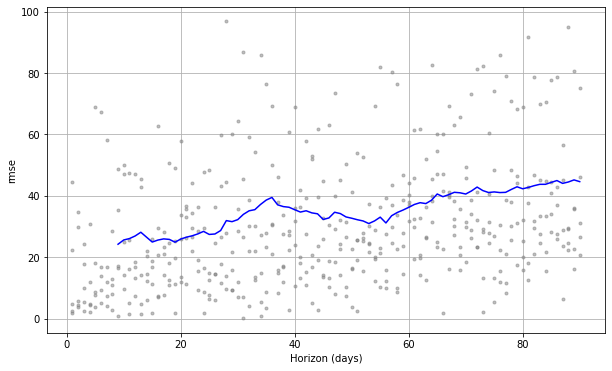

In [110]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')

In [31]:
df_prophet = df_time.loc[:,['CALL_SAVED_TIME','reason_for_call']].copy()
df_prophet = pd.DataFrame(df_prophet).copy()
df_prophet.columns = ['ds', 'y']

In [32]:
from fbprophet import Prophet
model = Prophet()
# fit the model
model.fit(df_prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds        yhat  yhat_lower  yhat_upper
0 2020-01-01   38.958002   16.787516   61.852499
1 2020-02-01   41.120772   18.482367   61.857245
2 2020-03-01   43.781385   22.233723   66.120751
3 2020-04-01   59.308835   36.792760   81.780432
4 2020-05-01  100.836929   80.131546  122.959177


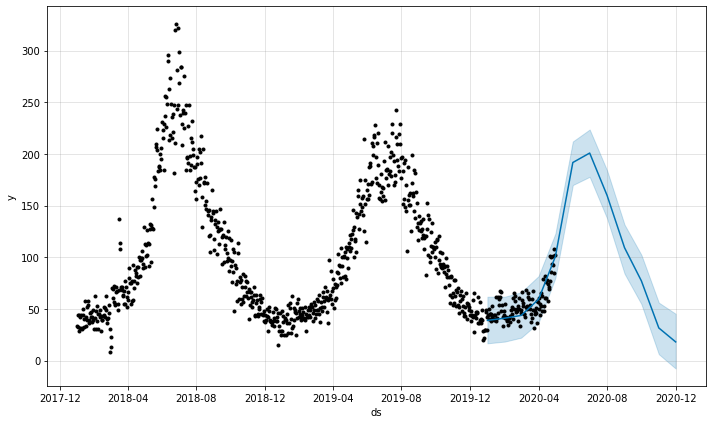

In [33]:
from datetime import datetime
# define the period for which we want a prediction
future = list()
for i in range(1, 13):
    date = '2020-%02d' % i
    future.append([date])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])
# use the model to make a forecast
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast)
plt.show()

In [34]:
#create 12 months of future data
future_data = model.make_future_dataframe(periods=24, freq = 'm')

#forecast the data for future data
forecast_data = model.predict(future_data)


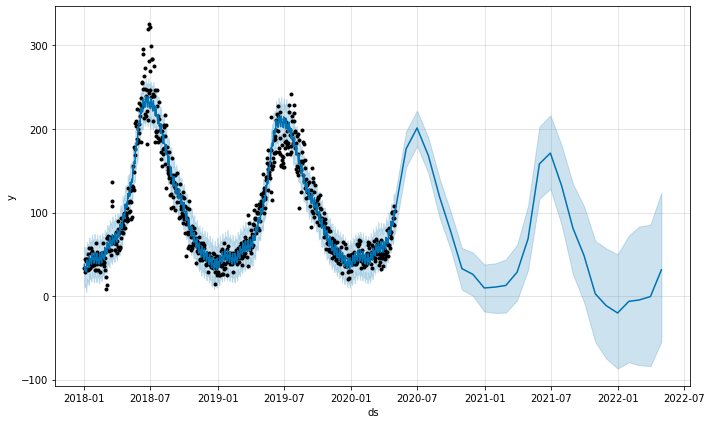

In [35]:
model.plot(forecast_data);

In [36]:
forecast = model.predict(future_data)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]


,ds,yhat,yhat_lower,yhat_upper
0,2018-01-01,38.102817,15.560170,59.363221
1,2018-01-02,31.315849,9.635870,52.672137
2,2018-01-03,31.987941,10.343061,54.921357
3,2018-01-04,33.735797,11.002755,55.953872
4,2018-01-05,34.803810,14.063156,55.691084
...,...,...,...,...
870,2021-12-31,-20.202733,-95.591925,50.688524
871,2022-01-31,-6.277543,-81.336362,68.791111
872,2022-02-28,-4.631944,-83.929833,75.989700
873,2022-03-31,-0.585718,-87.252907,85.784963


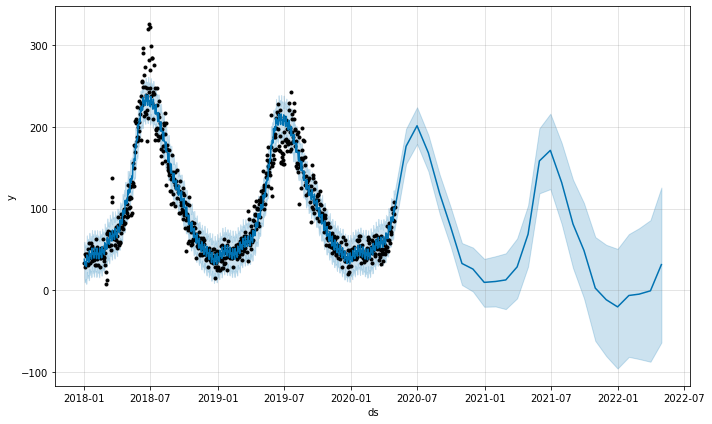

In [37]:
model.plot(forecast);

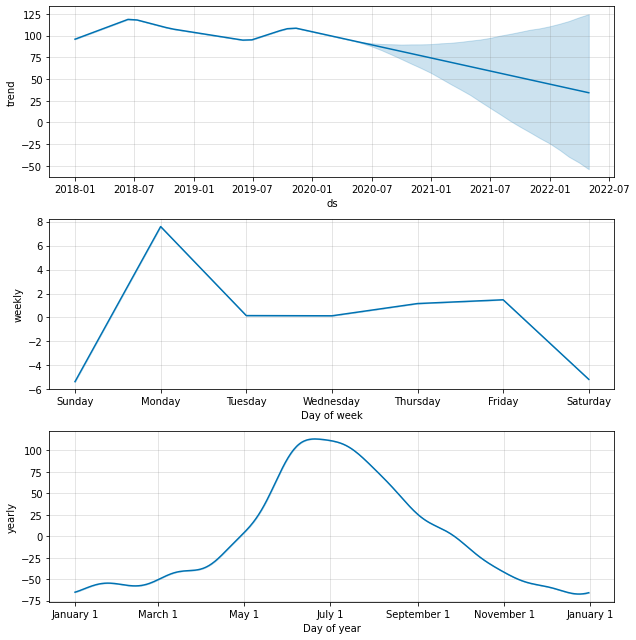

In [38]:
model.plot_components(forecast);

# Volume of calls

In [39]:
prophet_calls = calls.loc[:,['CALL_SAVED_TIME','type_of_calls']].copy()
prophet_calls = pd.DataFrame(prophet_calls).copy()
prophet_calls.columns = ['ds', 'y']

In [40]:
model_calls = Prophet()
model_calls.fit(prophet_calls)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


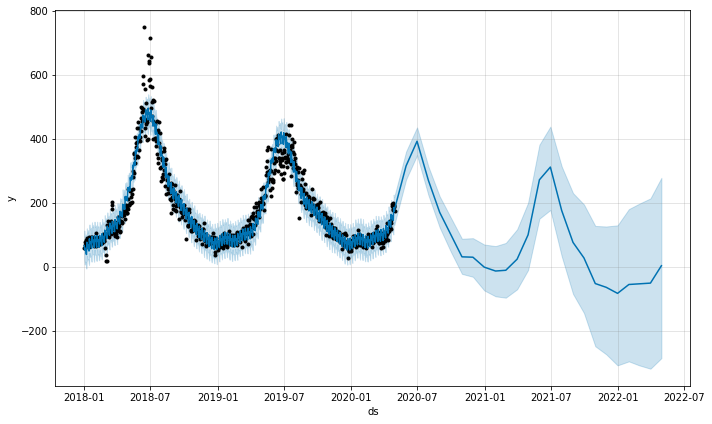

In [41]:
#create 12 months of future data
future_data = model_calls.make_future_dataframe(periods=24, freq = 'm')

#forecast the data for future data
forecast_data = model_calls.predict(future_data)

model_calls.plot(forecast_data);

In [42]:
forecast = model_calls.predict(future_data)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2018-01-01,65.836116,19.877911,108.205231
1,2018-01-02,51.924740,6.623121,97.533725
2,2018-01-03,51.347234,6.401252,95.235434
3,2018-01-04,57.301144,15.899450,102.637555
4,2018-01-05,56.123055,13.708302,99.282195
...,...,...,...,...
870,2021-12-31,-83.515247,-300.432909,119.473596
871,2022-01-31,-55.793498,-283.430479,158.996835
872,2022-02-28,-53.877065,-301.977074,169.513400
873,2022-03-31,-51.498564,-318.561586,182.245995


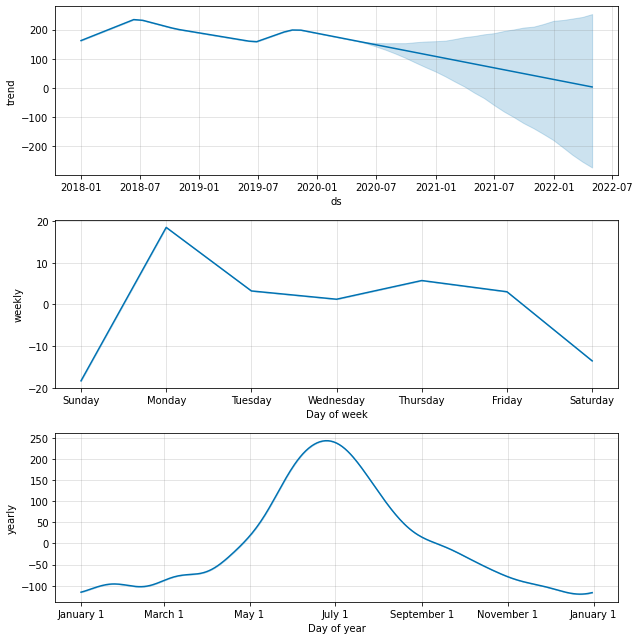

In [43]:
model_calls.plot_components(forecast);